In [1]:
import os
import numpy as np
import nibabel as nib
from itertools import product
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy.stats as stats
import helper_functions.visualizations as vis
import importlib
import helper_functions.reshape_data as rd
import helper_functions.filter_CT as fct
import helper_functions.manipulate_hull as mh
import cv2
import time
from scipy.io import loadmat
from scipy.ndimage import affine_transform

In [2]:
root_data_dir = '/Users/akre96/Documents/GradSchool/Class/BE223A/BE223A_2019/data' # Change for different systems
subject = 'subject_1'

# 'b' images seem to have fewer things around them, no pins in either
fluoro_jpeg_path = os.path.join(
    root_data_dir,
    os.path.join(
        subject,
        'fluoro_' + subject + '.jpg'
    )
)
hull_path = os.path.join(
    root_data_dir,
    os.path.join(
        subject,
        'hull_' + subject + '.nii'
    )
)

preop_CT_path = os.path.join(
    root_data_dir,
    os.path.join(
        subject,
        'preopCT_' + subject + '.nii'
    )
)

hull_mat_path = os.path.join(
    root_data_dir,
    os.path.join(
        subject,
        'hull.mat'
    )
)

In [3]:
preop_CT = nib.load(preop_CT_path)
preop_CT_data = preop_CT.get_fdata()
preop_CT_data.shape


(256, 256, 176)

/Users/akre96/Documents/GradSchool/Class/BE223A/BE223A_2019/CT_Segmentation/helper_functions/reshape_data.py:51: RuntimeWarning: Mean of empty slice
  projection = np.nanmean(ct_data, axis=axis)


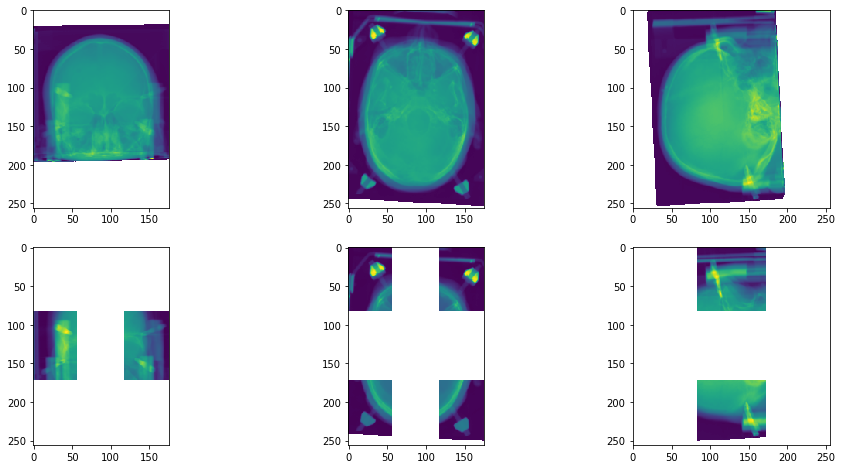

In [4]:
# Remove middle sections and edges to clean image
importlib.reload(fct)
filtered = fct.remove_ct_blocks(preop_CT_data, 35, 35, 35)
axes = vis.compare_filtered_original(preop_CT_data, filtered)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x12ffa7a90>,
      dtype=object)

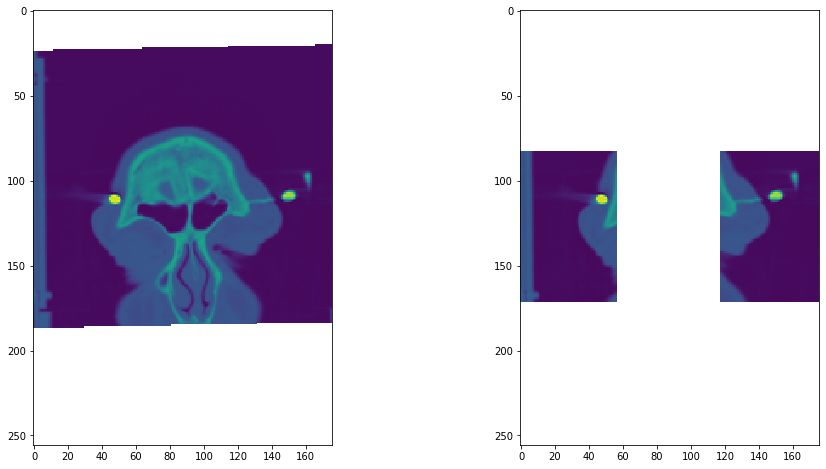

In [5]:
importlib.reload(vis)
vis.compare_slices([preop_CT_data, filtered], ['i'] * 2, [50] * 2)

# Using Scikit-image to find circles for the pin tips in 2D
- Goes through coronal plane slices to isolate circles

In [6]:
from skimage import data, color
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.feature import canny
from skimage.morphology import disk
from skimage.filters.rank import maximum
from skimage.draw import circle_perimeter


Normalizing from: -1601.8297119140625 3584.31884765625
To range: 0.0 1.0


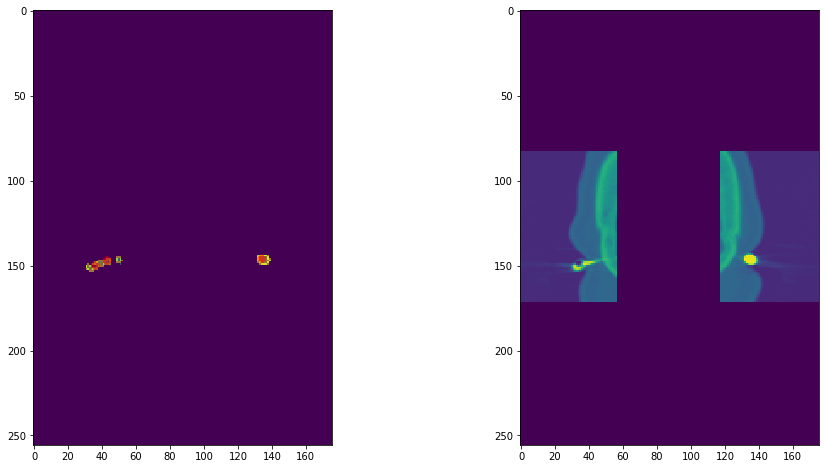

In [7]:
importlib.reload(fct)
min_max_filt = fct.min_max_normalize(filtered)
image_raw = np.nan_to_num(rd.get_slice(min_max_filt, 'i', 210))
max_filt_img = image_raw.copy()
max_filt_img[max_filt_img < .6] = 0

canny_filt = canny(max_filt_img, sigma=1)
# Detect two radii
hough_radii = np.arange(2, 10, 10)
hough_res = hough_circle(canny_filt, hough_radii)
# Select the most prominent 3 circles
accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii,
                                           total_num_peaks=3)

# Draw them
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(16, 8))
for center_y, center_x, radius in zip(cy, cx, radii):
    circy, circx = circle_perimeter(center_y, center_x, radius,
                                    shape=image_raw.shape)
    axes[0].plot(circx, circy, '-r', alpha=0.5)
axes[0].imshow(max_filt_img)
axes[0].imshow(canny_filt, alpha=.5)
axes[1].imshow(image_raw);

In [8]:
importlib.reload(fct)
pin_tip_ct = fct.isolate_pin_tips(
    filtered,
    threshold=0.6,
    hough_radii=np.arange(2, 10, 10)
)
pin_tip_ct.shape

Normalizing from: -1601.8297119140625 3584.31884765625
To range: 0.0 1.0


(256, 256, 176)

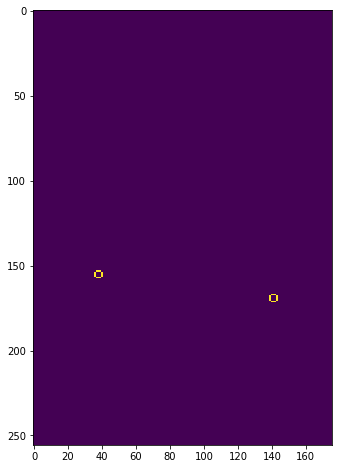

In [9]:
vis.plot_slice(pin_tip_ct, 'i', 75)

Plotting CT
Normalizing from: -1157.490478515625 3355.3486328125
To range: 0.0 1.0
Plotting features
Rendering


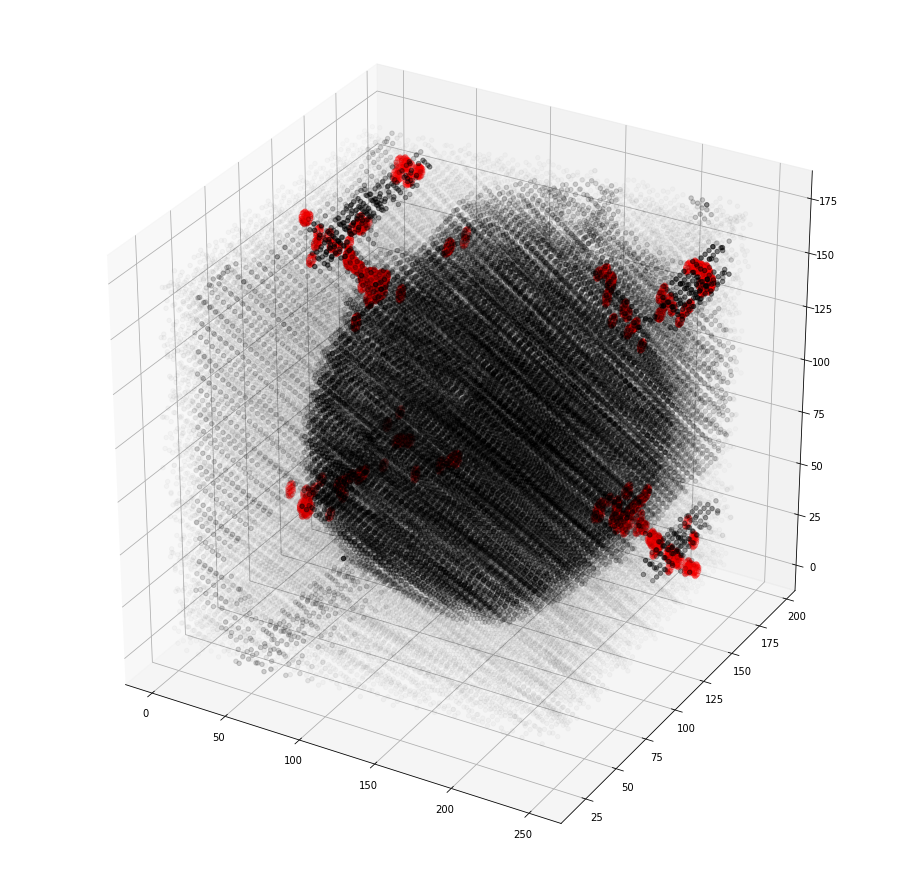

In [18]:
importlib.reload(vis)
print('Plotting CT')
ax = vis.quick_plot_3D(
    long_data,
    step_size=100,
    is_long=True
)
print('Plotting features')

vis.quick_plot_3D(
    pin_tip_ct/2,
    step_size=1,
    base_color=(1,0,0),
    is_norm=True,
    ax=ax
);
print('Rendering')

## Saving feature space CT using affine and header from original


In [13]:
feature_CT = nib.nifti2.Nifti2Image(pin_tip_ct, preop_CT.affine, header=preop_CT.header)

sizeof_hdr should be 540; set sizeof_hdr to 540


In [24]:
file_name = os.path.join(
    'output',
    subject + '_features.nii'
)
nib.nifti2.save(feature_CT, file_name)

# Loading hull and isolating skull

In [10]:
hull_idx = mh.load_hull_from_mat(hull_mat_path, preop_CT)
print('Long form hull shape:', hull_idx.shape)

Long form hull shape: (53814, 4)


## Checking if cortical hull imports/looks correct on its own and with the CT

In voxels hull shape: (256, 256, 176)


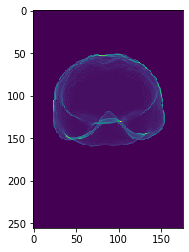

In [11]:
importlib.reload(rd)

hull_data = mh.load_hull_voxel_matrix(hull_mat_path, preop_CT)
print('In voxels hull shape:', hull_data.shape)
plt.imshow(rd.project_ct_2D(hull_data, 0))

Normalizing from: -1601.8297119140625 3584.31884765625
To range: 0.0 1.0


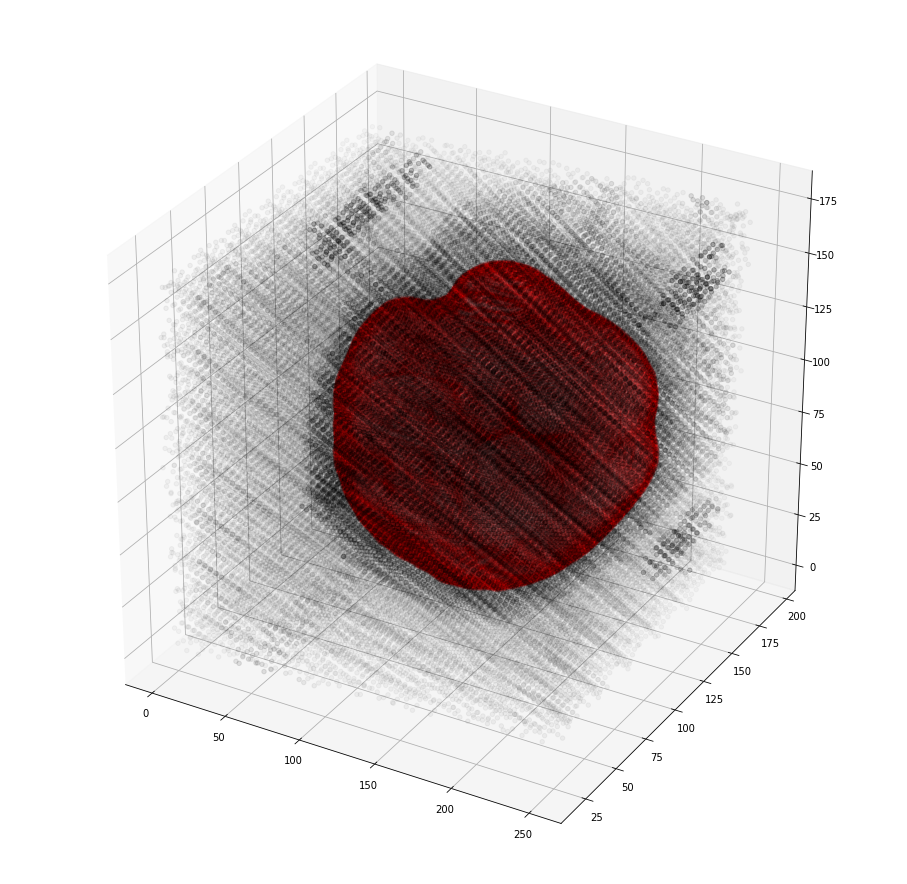

In [8]:
importlib.reload(vis)
ax = vis.quick_plot_3D(
    hull_idx,
    step_size=1,
    base_color=(1,0,0),
    is_norm=True,
    is_long=True,
    alpha_max=.1
)
vis.quick_plot_3D(
    fct.min_max_normalize(preop_CT_data),
    step_size=100,
    is_norm=True,
    is_long=False,
    ax=ax,
    alpha_max=0.5
)

In [12]:
from scipy.spatial import ConvexHull
from matplotlib.path import Path
importlib.reload(mh)
point_cloud = hull_idx[:,:3]
hull_hull = ConvexHull(point_cloud)
mh.isInHull([[100,100,100]], hull_hull)

array([ True])

In [15]:
long_data = rd.voxels_to_4D(fct.min_max_normalize(preop_CT_data), is_norm=True)

Normalizing from: -1601.8297119140625 3584.31884765625
To range: 0.0 1.0


In [27]:
importlib.reload(fct)
importlib.reload(mh)
hull_filt = fct.filter_in_hull(long_data, hull_hull, filt_out=True)

...Splitting data in to chunks
	Done. Chunks created: 140526
...Creating inputs
	Done
...Computing if chunks in Hull
	Done


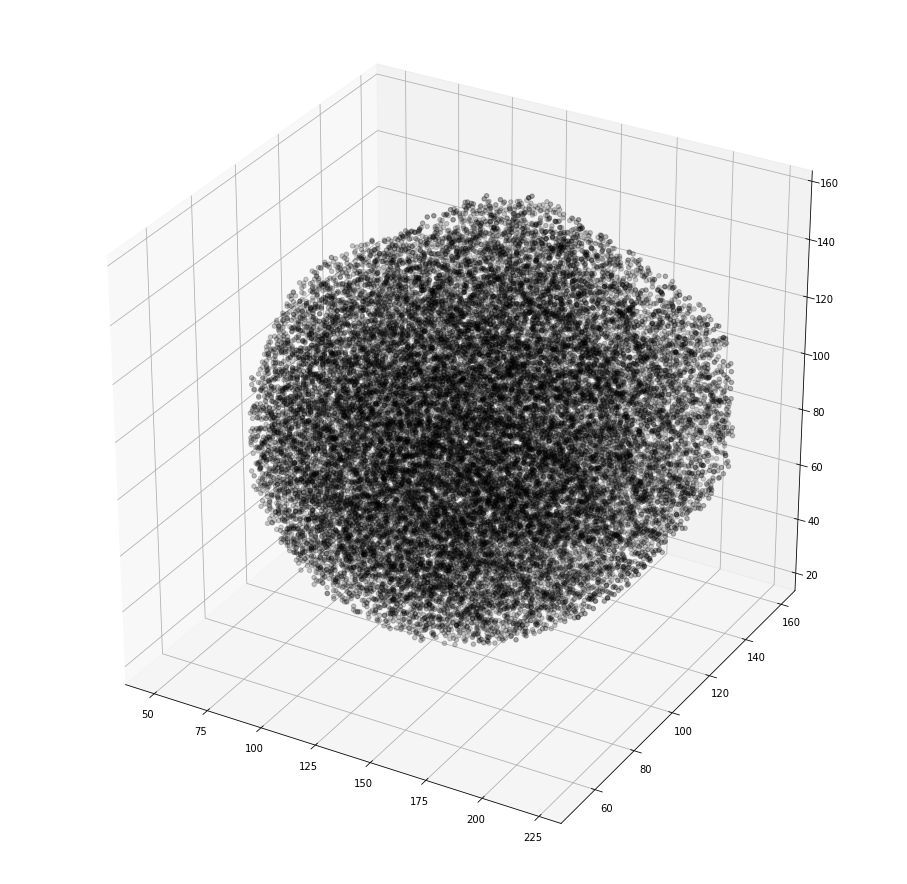

In [28]:
vis.quick_plot_3D(
    hull_filt,
    is_long=True,
    is_norm=True
)

### Find hull, remove inside from CT, scale hull, remove outside from CT

In [53]:
importlib.reload(mh)
scaled = mh.scale_hull(hull_idx, 1.1)

 40% (21799 of 53814) |#######           | Elapsed Time: 0:00:00 ETA:   0:00:00

[140.86661699 105.81296572  89.16020864]


100% (53814 of 53814) |##################| Elapsed Time: 0:00:00 Time:  0:00:00


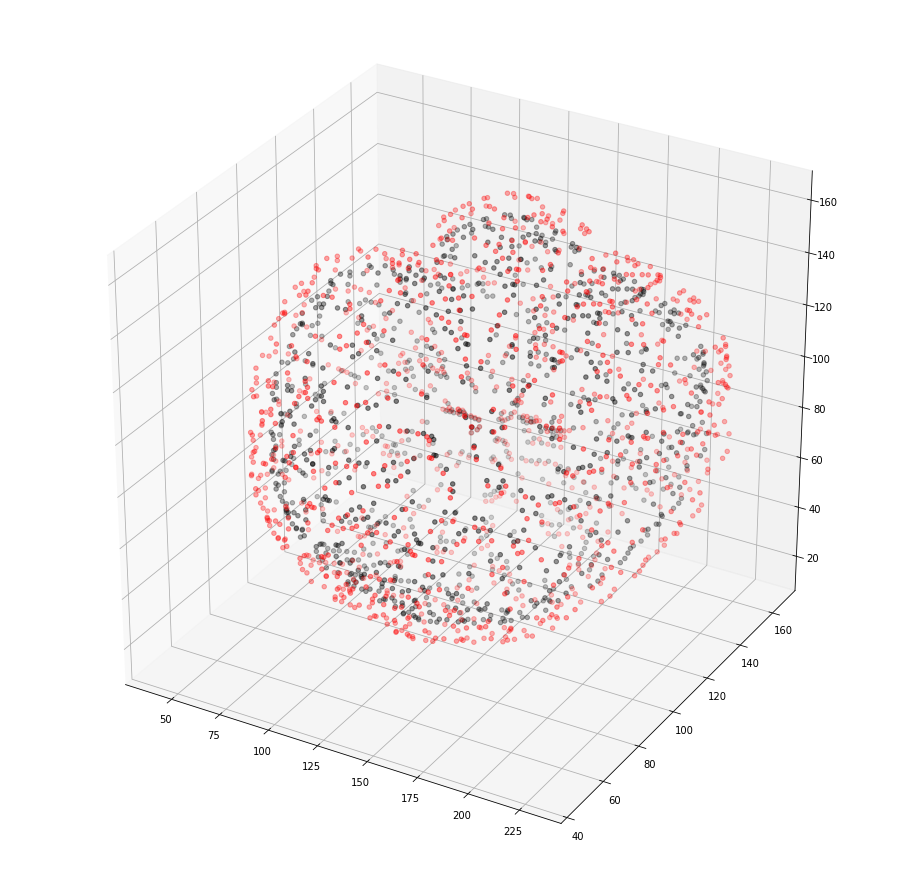

In [55]:
ax = vis.quick_plot_3D(
    hull_idx,
    is_long=True,
    is_norm=True,
    alpha_max=0.5
)
vis.quick_plot_3D(
    scaled,
    is_long=True,
    is_norm=True,
    alpha_max=0.5,
    ax=ax,
    base_color=(1,0,0)
)

In [57]:
scaled_hull = ConvexHull(scaled[:,:3])
hull_filt_in = fct.filter_in_hull(long_data, hull_hull, filt_out=False)
hull_filt_both = fct.filter_in_hull(hull_filt_in, scaled_hull, filt_out=True)

...Splitting data in to chunks
	Done. Chunks created: 140526
...Creating inputs
	Done
...Computing if chunks in Hull
	Done
...Splitting data in to chunks
	Done. Chunks created: 113190
...Creating inputs
	Done
...Computing if chunks in Hull
	Done


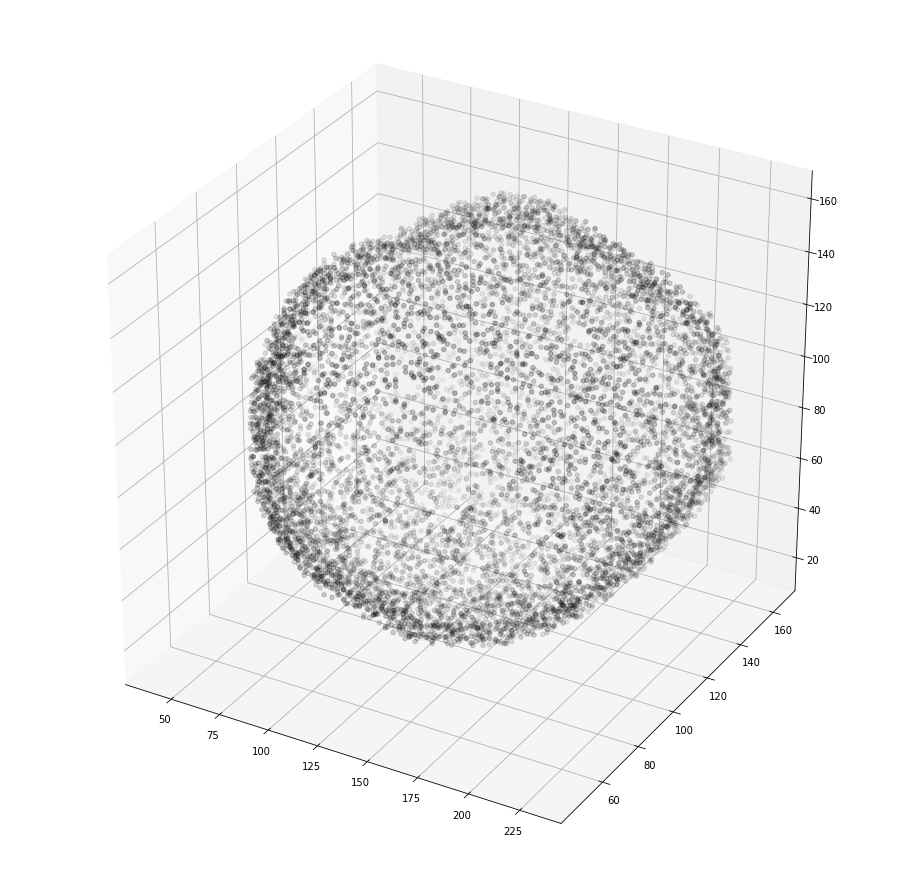

In [58]:
vis.quick_plot_3D(
    hull_filt_both,
    is_long=True,
    is_norm=True,
    alpha_max=0.5
)

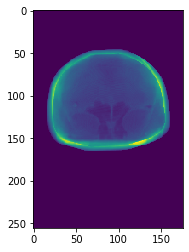

In [64]:
voxel_filt = rd.long_to_voxels(hull_filt_both, preop_CT_data.shape)
plt.imshow(rd.project_ct_2D(voxel_filt, 0))

In [65]:
preop_CT_data.shape

(256, 256, 176)